<a href="https://colab.research.google.com/github/Radi4/DL_colab/blob/master/homework04_basic_part1_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing with Deep Learning (7 points)

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (13, 6)

In [0]:
from tqdm import tnrange

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#cp from gdrive
!cp ./gdrive/'My Drive'/Train_rev1.csv ./

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [6]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)['FullDescription']

194565    Fresh Medical Recruitment has a new opportunit...
192333    You will delivering Gravel Quarry products in ...
103387    The Londonoffice of this large multidisciplina...
Name: FullDescription, dtype: object

In [7]:
data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
138197,70438691,CAD Technician,"Our client, an established and versatile pract...","Eastbourne, South East",Eastbourne,NaN,permanent,Conrad Consulting Ltd,Engineering Jobs,26000 - 32000/annum,29000,cv-library.co.uk,10.275085
226983,72443178,Sales Manager,JOB TITLE: Sales Manager – Artificial Grass LO...,London South East,South East London,NaN,permanent,Dexter Nicholas,Sales Jobs,"From 25,000 to 35,000 per annum + commission +...",30000,totaljobs.com,10.308986
189252,71708471,Quality Supervisor,Job Title: Quality Supervisor Reports to: Opex...,"Slough, Berkshire",Slough,full_time,permanent,Orion Electrotech,IT Jobs,45000-45000,45000,fish4.co.uk,10.714440


### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [8]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [0]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [10]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [0]:
def increase_token_counts(token_counts, tokens):
  for token in tokens.split(' '):
    token_counts[token] += 1

In [12]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in "Title" and "FullDescription"
data["Title"].apply(lambda tokens : increase_token_counts(token_counts, tokens))
data["FullDescription"].apply(lambda tokens : increase_token_counts(token_counts, tokens))
'Finish'

'Finish'

In [13]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Text(0.5, 0, 'Counts')

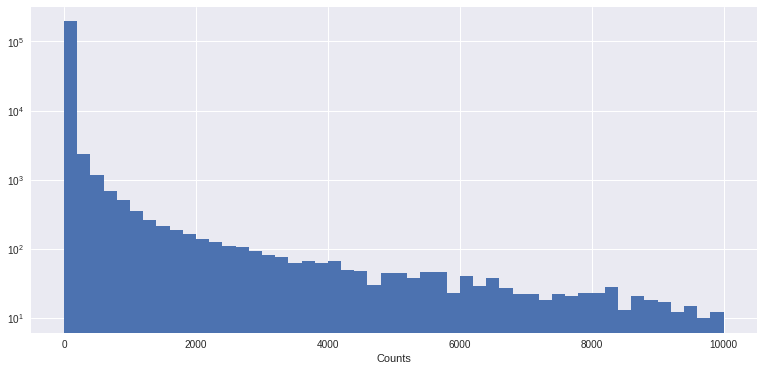

In [14]:
# Let's see how many words are there for each count

_ = plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [0]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for token, val in token_counts.items() if val >= min_count]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [16]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [0]:
token_to_id = {token : index for index, token in enumerate(tokens)}

In [18]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [0]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i, seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [20]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[   2    3    4    1    1]
 [ 998  176    1    1    1]
 [  18 3472  242   59    6]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [21]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
        sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [22]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [0]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [24]:
generate_batch(data_train, 3, max_len=10)

{'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'FullDescription': array([[   59,  2555,   944,    73,   561,    18,   101,  1563,   622,
            86],
        [ 1072,    88,  4053,    74,    86,    74,  2001,    15,   439,
          1942],
        [ 9975,  1969,  7471,    63, 27991,  1166,  3540,    64,  1464,
           561]], dtype=int32),
 'Log1pSalary': array([10.463132, 10.558439, 10.064798], dtype=float32),
 'Title': array([[  18,  101, 1563,  622],
        [1072,   88, 4053,    1],
        [ 237,  347,  155,   62]], dtype=int32)}

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [0]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [0]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX).cuda()
        self.conv = nn.Conv1d(64, out_size, kernel_size=3, padding=1).cuda()
        self.pool = GlobalMaxPooling().cuda()
        self.relu = nn.ReLU().cuda()
        self.dense = nn.Linear(out_size, out_size).cuda()

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense. 
        return self.dense(self.relu(self.pool(self.conv(h))))

In [119]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title'])).cuda()
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


__Task 2.1__ Create description encoder

In [0]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX).cuda()
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1).cuda()
        self.relu1 = nn.ReLU().cuda()
        self.pool1 = nn.MaxPool1d(2).cuda()
        self.conv2 = nn.Conv1d(out_size, out_size * 2, kernel_size=3, padding=1).cuda()
        self.pool2 = GlobalMaxPooling().cuda()
        self.relu2 = nn.ReLU().cuda()
        self.dense = nn.Linear(out_size * 2, out_size).cuda()

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense. 
        return self.dense(self.relu2(self.pool2(self.conv2(self.pool1(self.relu1(self.conv1(h)))))))

In [121]:
desc_encoder = DescriptionEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription'])).cuda()
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


__Task 2.2__ Build one network ~~to rule them all~~

In [0]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescriptionEncoder(out_size = 128)
        
        # define layers for categorical features. A few dense layers would do.
        self.dense_1 = nn.Linear(n_cat_features, 512).cuda()
        self.relu_1 = nn.ReLU().cuda()
        self.dense_2 = nn.Linear(512, 256).cuda()
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.output = nn.Linear(64 + 128 + 256, 1024).cuda()
        self.out_relu = nn.ReLU().cuda()
        self.predict = nn.Linear(1024, 1).cuda()
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.dense_2(self.relu_1(self.dense_1(cat_features)))
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        
        output = self.predict(self.out_relu(self.output(joint_h)))
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return output[:, 0]

In [0]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [0]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = torch.tensor(batch["Title"], dtype=torch.int64).cuda()
desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).cuda()
cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).cuda()
reference = torch.tensor(batch[target_column], dtype=torch.float32).cuda()

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [0]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference) - torch.exp(prediction)).mean()

In [0]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [0]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [0]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [38]:
train_losses = np.zeros(num_epochs).astype(float)
val_losses = np.zeros(num_epochs).astype(float)

train_maes = np.zeros(num_epochs).astype(float)
val_maes = np.zeros(num_epochs).astype(float) 

for epoch_i in tnrange(num_epochs):
    
    if epoch_i % 10 == 0:
      print("Training after {} epochs".format(epoch_i + 1))
    
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch, verbose = False):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64).cuda()
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).cuda()
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).cuda()
        reference = torch.tensor(batch[target_column], dtype=torch.float32).cuda()

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.cpu().data.numpy()
        train_mae += compute_mae(reference, prediction).cpu().data.numpy()
        train_batches += 1
    
    train_losses[epoch_i] = train_loss / train_batches
    train_maes[epoch_i] = train_mae / train_batches
    
    if epoch_i % 10 == 0:
      print("\tLoss:\t%.5f" % (train_loss / train_batches))
      print("\tMAE:\t%.5f" % (train_mae / train_batches))
      print('\n\n')
    
    if epoch_i % 10 == 0:
      print("Validation after {} epochs".format(epoch_i + 1))
    
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    for batch in iterate_minibatches(data_val, shuffle=False, verbose = False):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64).cuda()
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).cuda()
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).cuda()
        reference = torch.tensor(batch[target_column], dtype=torch.float32).cuda()
        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.cpu().data.numpy()
        val_mae += compute_mae(reference, prediction).cpu().data.numpy()
        val_batches += 1
    
    val_losses[epoch_i] = val_loss / val_batches
    val_maes[epoch_i] = val_mae / val_batches
    
    if epoch_i % 10 == 0:  
      print("\tLoss:\t%.5f" % (val_loss / val_batches))
      print("\tMAE:\t%.5f" % (val_mae / val_batches))
      print('\n\n')

Training after 1 epochs
	Loss:	5.12113
	MAE:	140329.10532



Validation after 1 epochs
	Loss:	0.27308
	MAE:	13494.76517



Training after 11 epochs
	Loss:	0.11932
	MAE:	9069.55115



Validation after 11 epochs
	Loss:	0.10976
	MAE:	8481.86540



Training after 21 epochs
	Loss:	0.11495
	MAE:	9037.69738



Validation after 21 epochs
	Loss:	0.11688
	MAE:	8623.19320



Training after 31 epochs
	Loss:	0.10534
	MAE:	8746.80283



Validation after 31 epochs
	Loss:	0.08914
	MAE:	7610.03180



Training after 41 epochs
	Loss:	0.09522
	MAE:	8274.07944



Validation after 41 epochs
	Loss:	0.08484
	MAE:	7483.40907



Training after 51 epochs
	Loss:	0.08353
	MAE:	7598.00842



Validation after 51 epochs
	Loss:	0.07840
	MAE:	7204.56946



Training after 61 epochs
	Loss:	0.08359
	MAE:	7738.16387



Validation after 61 epochs
	Loss:	0.08288
	MAE:	7360.48185



Training after 71 epochs
	Loss:	0.08462
	MAE:	7631.05591



Validation after 71 epochs
	Loss:	0.18449
	MAE:	11010.02406



Training after 81 epoc

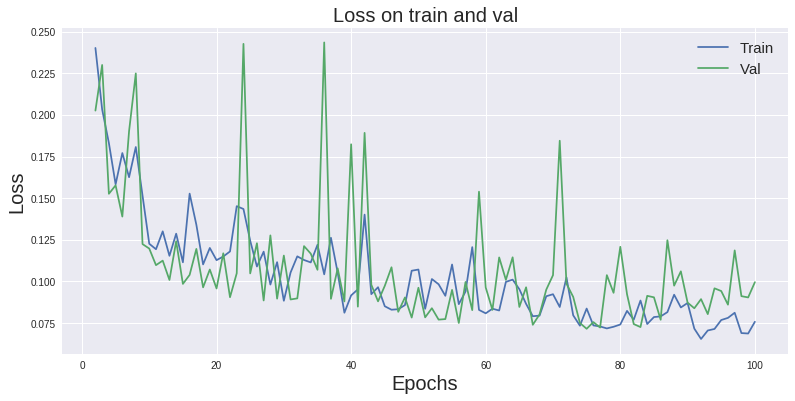

In [39]:
plt.plot(range(2, num_epochs + 1), train_losses[1:], label = 'Train')
plt.plot(range(2, num_epochs + 1), val_losses[1:], label = 'Val')
plt.legend(loc = 'best',  prop={'size': 15})
plt.title('Loss on train and val', size = 20)
plt.xlabel('Epochs', size = 20)
plt.ylabel('Loss', size = 20)
plt.show()

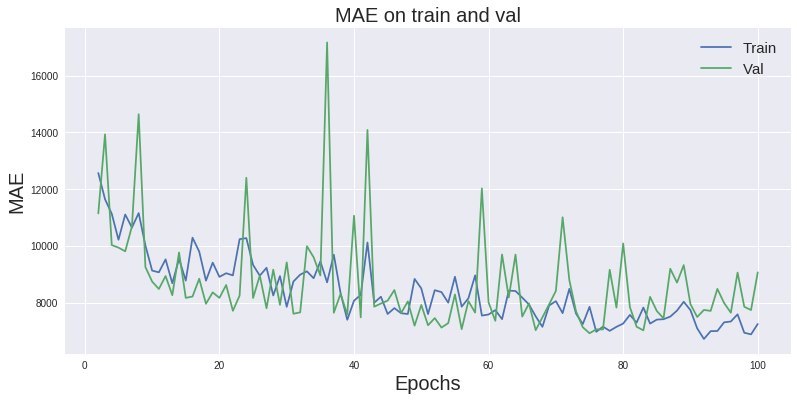

In [40]:
plt.plot(range(2, num_epochs + 1), train_maes[1:], label = 'Train')
plt.plot(range(2, num_epochs + 1), val_maes[1:], label = 'Val')
plt.legend(loc = 'best',  prop={'size': 15})
plt.title('MAE on train and val', size = 20)
plt.xlabel('Epochs', size = 20)
plt.ylabel('MAE', size = 20)
plt.show()

In [41]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

for batch in iterate_minibatches(data_val, shuffle=False):
    title_ix = torch.tensor(batch["Title"], dtype=torch.int64).cuda()
    desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).cuda()
    cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).cuda()
    reference = torch.tensor(batch[target_column], dtype=torch.float32).cuda()

    prediction = model(title_ix, desc_ix, cat_features)
    loss = compute_loss(reference, prediction)

    val_loss += loss.cpu().data.numpy()
    val_mae += compute_mae(reference, prediction).cpu().data.numpy()
    val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:



	Loss:	0.09952
	MAE:	9069.31266





In [42]:
print("Best val loss during iteration = {} on epoch = {}, MAE on this epoch = {}"\
      .format(np.min(val_losses), np.argmin(val_losses) + 1, val_maes[np.argmin(val_losses)]))
print("Best val MAE during iteration = {} on epoch = {}, loss on this epoch = {}"\
      .format(np.min(val_maes), np.argmin(val_maes) + 1, val_losses[np.argmin(val_maes)]))

Best val loss during iteration = 0.07153192749794791 on epoch = 75, MAE on this epoch = 6922.665586065155
Best val MAE during iteration = 6922.665586065155 on epoch = 75, loss on this epoch = 0.07153192749794791


Видно что val-loss очень сильно скачет, но в целом есть некий тренд на убывание (так же это косвено доказывается тем, что наилучшие значения метрик были в эпохах после 70). Попытаемся улучшить модель с помощью дальнейших усложнений в Task 4

### Task 3: explaining network predictions

It's usually a good idea to understand what your model does before you let it make actual decisions. It's simple for linear models: just see which words learned positive or negative weights. However, its much harder for neural networks that learn complex nonlinear dependencies.

There are, however, some ways to look inside the black box:
* Seeing how model responds to input perturbations
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

Today we gonna try the first method just because it's the simplest one.

__Your task__ is to measure how does model prediction change if you replace certain tokens with UNKs. The core idea is that if dropping a word from text causes model to predict lower log-salary, than this word probably has positive contribution to salary (and vice versa).

In [0]:
def drop_token(sample, index):
  tensor = torch.tensor(sample, dtype=torch.int64).cuda()
  tensor[0, index] = UNK_IX
  return tensor

def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """
    
    batch = generate_batch(pd.DataFrame([sample]), 1)
    title_ix = torch.tensor(batch["Title"], dtype=torch.int64).cuda()
    desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).cuda()
    cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).cuda()
    #assert(sample[col_name].shape[0] == 1)
    # compute model prediction on sample (scalar float log-salary)
 
    baseline_pred = model(title_ix, desc_ix, cat_features).cpu().data.numpy()
    
    # for each i-th token in :col_name:, compute predictions on a copy of data
    # where i-th token is dropped (UNK)
    predictions_without_word = [0] * batch[col_name].shape[1]
    
    for i in range(batch[col_name].shape[1]):
      if col_name == 'Title':
        title_ix = drop_token(batch[col_name], i)
      elif col_name == 'FullDescription':
        desc_ix = drop_token(batch[col_name], i)
      else:
        raise RuntimeError
      
      predictions_without_word[i] = model(title_ix, desc_ix, cat_features).cpu().data.numpy()
    
    score_differences = [
        prediction - baseline_pred for prediction in predictions_without_word
    ]
    
    # return a list of pairs: [(token, score_difference)]
    sample_text = sample[col_name].split()
    return [(sample_text[i], score_differences[i]) for i in range(batch[col_name].shape[1])]

In [44]:
# debugging area
sample = data.loc[np.random.randint(len(data))]
print("Input:", sample)

tokens_and_weights = explain(model, sample, "Title")
print(tokens_and_weights)

Input: Id                                                             66537290
Title                                                car park attendant
FullDescription       our client requires a car park attendant to st...
LocationRaw                                                  Warrington
LocationNormalized                                           Warrington
ContractType                                                  full_time
ContractTime                                                        NaN
Company                                                           Other
Category                                         Customer Services Jobs
SalaryRaw                                          6.19 - 6.19 per hour
SalaryNormalized                                                  11884
SourceName                                               Jobcentre Plus
Log1pSalary                                                     9.38303
Name: 11495, dtype: object
[('car', array([-0.07918262], 

In [0]:
from IPython.display import HTML, display_html

def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):
    
    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(weight)), bytes=True)
        return '#%02X%02X%02X' % (rgba[0, 0], rgba[0,1], rgba[0, 2])
    
    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]
    
    
    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))
        
    return raw_html
    

In [46]:
i = np.random.randint(len(data))
sample = data.loc[i]
print("Index:", i)

# predict salary on sample
batch = generate_batch(pd.DataFrame([sample]), 1)
title_ix = torch.tensor(batch["Title"], dtype=torch.int64).cuda()
desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).cuda()
cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).cuda()
print("Salary (gbp):", model(title_ix, desc_ix, cat_features))

tokens_and_weights = explain(model, sample, "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, sample, "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Index: 60011
Salary (gbp): tensor([9.8743], device='cuda:0', grad_fn=<SelectBackward>)


purchase ledger clerk

purchase ledger clerk required to work within a busy finance department . responsibilities of the role will include processing purchase invoices , reconciling supplier statements , foreign payments , managing payments by bacs and cheque , dealing with queries and maintaining an accurate system . the successful applicant will need to come from a solid purchase ledger background and be immediately available . you must have high volume processing experience and exceptional communication skills . applicants will also need competent excel systems skills including macros and pivots . my client is a leicestershire based company who boast an easily accessible location , open plan offices , a strong and knowledgeable management team and a work hard , play hard culture . the team you will be working with are welcoming and friendly . only applicants with a suitable amount of uk based experience and who have a legal right to work within the uk will be considered . as a result of the volume of applications , in some instances we are unable to respond with individual feedback . if we have not contacted you within five working days of your application , then you can assume that your application will not be progressed further for this role . this job was originally posted as www . totaljobs . com / jobseeking / purchaseledgerclerk_job ****

Как видим мы закрасили те слова, которые влияют на зарплату (например слово manager явно влияет)

### Task 4: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into 

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

Я буду реализовывать пункт и смотреть изменилось ли качество. Для удобства мы загоним код тренировки в одну функцию

In [0]:
def train_model(model, opt, num_epochs = 100, max_len = 100, batch_size = 32, batches_per_epoch = 100):
    train_losses = np.zeros(num_epochs).astype(float)
    val_losses = np.zeros(num_epochs).astype(float)

    train_maes = np.zeros(num_epochs).astype(float)
    val_maes = np.zeros(num_epochs).astype(float) 

    for epoch_i in tnrange(num_epochs):
    
        if epoch_i % 10 == 0:
            print("Training after {} epochs".format(epoch_i + 1))
    
        train_loss = train_mae = train_batches = 0    
        model.train(True)
    
        for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch, verbose = False):
            title_ix = torch.tensor(batch["Title"], dtype=torch.int64).cuda()
            desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).cuda()
            cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).cuda()
            reference = torch.tensor(batch[target_column], dtype=torch.float32).cuda()

            prediction = model(title_ix, desc_ix, cat_features)

            loss = compute_loss(reference, prediction)
            loss.backward()
            opt.step()
            opt.zero_grad()

            train_loss += loss.cpu().data.numpy()
            train_mae += compute_mae(reference, prediction).cpu().data.numpy()
            train_batches += 1
    
        train_losses[epoch_i] = train_loss / train_batches
        train_maes[epoch_i] = train_mae / train_batches
    
        if epoch_i % 10 == 0:
            print("\tLoss:\t%.5f" % (train_loss / train_batches))
            print("\tMAE:\t%.5f" % (train_mae / train_batches))
            print('\n\n')
    
        if epoch_i % 10 == 0:
            print("Validation after {} epochs".format(epoch_i + 1))
    
        val_loss = val_mae = val_batches = 0
        model.train(False)
    
        for batch in iterate_minibatches(data_val, shuffle=False, verbose = False):
            title_ix = torch.tensor(batch["Title"], dtype=torch.int64).cuda()
            desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).cuda()
            cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).cuda()
            reference = torch.tensor(batch[target_column], dtype=torch.float32).cuda()
            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.cpu().data.numpy()
            val_mae += compute_mae(reference, prediction).cpu().data.numpy()
            val_batches += 1
    
        val_losses[epoch_i] = val_loss / val_batches
        val_maes[epoch_i] = val_mae / val_batches
    
        if epoch_i % 10 == 0:  
            print("\tLoss:\t%.5f" % (val_loss / val_batches))
            print("\tMAE:\t%.5f" % (val_mae / val_batches))
            print('\n\n')

    return train_losses, train_maes, val_losses, val_maes

In [126]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
train_losses, train_maes, val_losses, val_maes = train_model(model, opt)

Training after 1 epochs
	Loss:	5.02926
	MAE:	97678.61133



Validation after 1 epochs
	Loss:	0.28902
	MAE:	12912.15798



Training after 11 epochs
	Loss:	0.12518
	MAE:	9423.28320



Validation after 11 epochs
	Loss:	0.11415
	MAE:	9050.15605



Training after 21 epochs
	Loss:	0.11575
	MAE:	8824.35574



Validation after 21 epochs
	Loss:	0.09777
	MAE:	8359.71052



Training after 31 epochs
	Loss:	0.11324
	MAE:	8909.03605



Validation after 31 epochs
	Loss:	0.08425
	MAE:	7530.18058



Training after 41 epochs
	Loss:	0.09412
	MAE:	8313.91961



Validation after 41 epochs
	Loss:	0.08680
	MAE:	7582.60610



Training after 51 epochs
	Loss:	0.08485
	MAE:	7672.40708



Validation after 51 epochs
	Loss:	0.08552
	MAE:	7687.93296



Training after 61 epochs
	Loss:	0.08245
	MAE:	7568.51891



Validation after 61 epochs
	Loss:	0.08199
	MAE:	7383.23861



Training after 71 epochs
	Loss:	0.08322
	MAE:	7408.83756



Validation after 71 epochs
	Loss:	0.07530
	MAE:	7034.60165



Training after 81 epochs

In [132]:
print("Best val loss during iteration = {} on epoch = {}, MAE on this epoch = {}"\
      .format(np.min(val_losses), np.argmin(val_losses) + 1, val_maes[np.argmin(val_losses)]))
print("Best val MAE during iteration = {} on epoch = {}, loss on this epoch = {}"\
      .format(np.min(val_maes), np.argmin(val_maes) + 1, val_losses[np.argmin(val_maes)]))

Best val loss during iteration = 0.06805217543896896 on epoch = 100, MAE on this epoch = 6715.162307559743
Best val MAE during iteration = 6715.162307559743 on epoch = 100, loss on this epoch = 0.06805217543896896


In [0]:
train_loss_experiments = []
train_mae_experiments = []
val_loss_experiments = []
val_mae_experiments = []

In [0]:
train_loss_experiments.append((np.copy(train_losses), 'before experiments'))
train_mae_experiments.append((np.copy(train_maes), 'before experiments'))

val_loss_experiments.append((np.copy(val_losses), 'before experiments'))
val_mae_experiments.append((np.copy(val_maes), 'before experiments'))

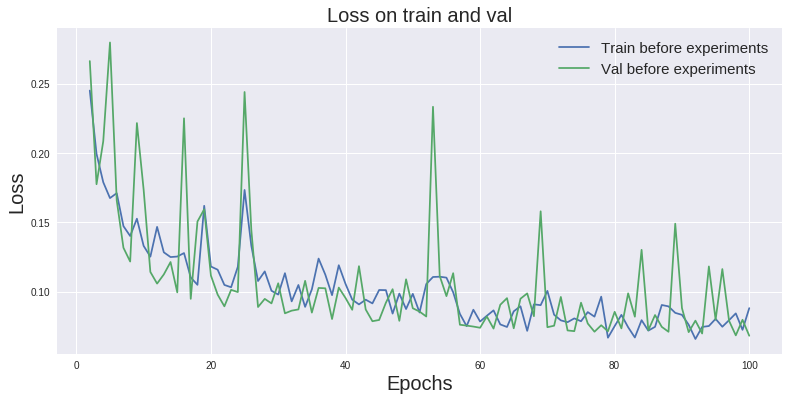

In [135]:
for i in range(len(train_loss_experiments)):
  num_epochs = train_loss_experiments[i][0].shape[0]
  plt.plot(range(2, num_epochs + 1), train_loss_experiments[i][0][1:], label = 'Train ' + train_loss_experiments[i][1])
  plt.plot(range(2, num_epochs + 1), val_loss_experiments[i][0][1:], label = 'Val ' + val_loss_experiments[i][1])

plt.legend(loc = 'upper right',  prop={'size': 15})
plt.title('Loss on train and val', size = 20)
plt.xlabel('Epochs', size = 20)
plt.ylabel('Loss', size = 20)
plt.show()

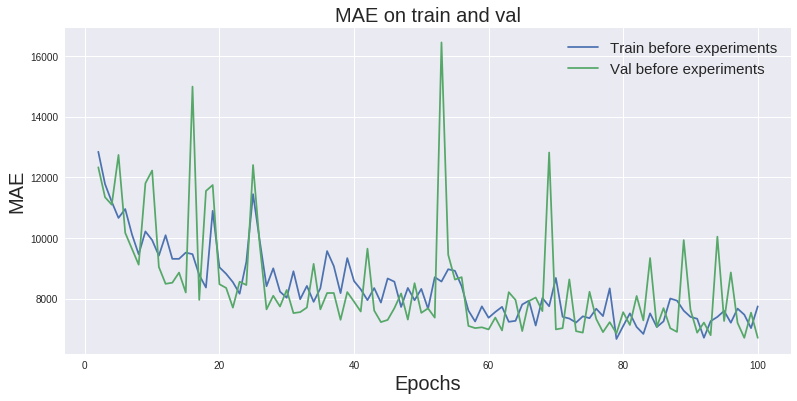

In [136]:
for i in range(len(train_mae_experiments)):
  num_epochs = train_mae_experiments[i][0].shape[0]
  plt.plot(range(2, num_epochs + 1), train_mae_experiments[i][0][1:], label = 'Train ' + train_mae_experiments[i][1])
  plt.plot(range(2, num_epochs + 1), val_mae_experiments[i][0][1:], label = 'Val ' + val_mae_experiments[i][1])

plt.legend(loc = 'upper right',  prop={'size': 15})
plt.title('MAE on train and val', size = 20)
plt.xlabel('Epochs', size = 20)
plt.ylabel('MAE', size = 20)
plt.show()

## A

### Add batchnorm

In [0]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX).cuda()
        self.conv = nn.Conv1d(64, out_size, kernel_size=3, padding=1).cuda()
        self.norm = nn.BatchNorm1d(out_size).cuda()
        self.pool = GlobalMaxPooling().cuda()
        self.relu = nn.ReLU().cuda()
        self.dense = nn.Linear(out_size, out_size).cuda()

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense. 
        return self.dense(self.relu(self.pool(self.norm(self.conv(h)))))

In [0]:
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX).cuda()
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1).cuda()
        self.norm1 = nn.BatchNorm1d(out_size).cuda()
        self.relu1 = nn.ReLU().cuda()
        self.pool1 = nn.MaxPool1d(2).cuda()
        
        self.conv2 = nn.Conv1d(out_size, out_size * 2, kernel_size=3, padding=1).cuda()
        self.norm2 = nn.BatchNorm1d(out_size * 2).cuda()
        self.pool2 = GlobalMaxPooling().cuda()
        self.relu2 = nn.ReLU().cuda()
        
        self.dense = nn.Linear(out_size * 2, out_size).cuda()

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense. 
        return self.dense(self.relu2(self.pool2(self.norm2(self.conv2(self.pool1(self.relu1(self.norm1(self.conv1(h)))))))))

In [0]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.title_norm = nn.BatchNorm1d(64).cuda()
        
        self.desc_encoder = DescriptionEncoder(out_size = 128)
        self.desc_norm = nn.BatchNorm1d(128).cuda()
        
        # define layers for categorical features. A few dense layers would do.
        self.dense_1 = nn.Linear(n_cat_features, 512).cuda()
        self.norm_1 = nn.BatchNorm1d(512).cuda()
        self.relu_1 = nn.ReLU().cuda()
        self.dense_2 = nn.Linear(512, 256).cuda()
        self.norm_2 = nn.BatchNorm1d(256).cuda()
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.output = nn.Linear(64 + 128 + 256, 1024).cuda()
        self.out_norm = nn.BatchNorm1d(1024).cuda()
        self.out_relu = nn.ReLU().cuda()
        self.predict = nn.Linear(1024, 1).cuda()
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_norm(self.title_encoder(title_ix))
        desc_h = self.desc_norm(self.desc_encoder(desc_ix))
        
        # apply categorical encoder
        cat_h = self.norm_2(self.dense_2(self.relu_1(self.norm_1(self.dense_1(cat_features)))))
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        
        output = self.predict(self.out_relu(self.out_norm(self.output(joint_h))))
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return output[:, 0]

In [149]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
train_losses, train_maes, val_losses, val_maes = train_model(model, opt)

Training after 1 epochs
	Loss:	18.06080
	MAE:	49771.51832



Validation after 1 epochs
	Loss:	1.70072
	MAE:	82644.24650



Training after 11 epochs
	Loss:	0.28908
	MAE:	15124.32660



Validation after 11 epochs
	Loss:	0.22909
	MAE:	11924.60977



Training after 21 epochs
	Loss:	0.17450
	MAE:	11216.54589



Validation after 21 epochs
	Loss:	0.16357
	MAE:	10522.05437



Training after 31 epochs
	Loss:	0.13947
	MAE:	9826.35408



Validation after 31 epochs
	Loss:	0.20159
	MAE:	11210.83768



Training after 41 epochs
	Loss:	0.11426
	MAE:	8976.02580



Validation after 41 epochs
	Loss:	0.12485
	MAE:	9198.35358



Training after 51 epochs
	Loss:	0.11440
	MAE:	8823.72304



Validation after 51 epochs
	Loss:	0.09148
	MAE:	7961.51482



Training after 61 epochs
	Loss:	0.09189
	MAE:	7991.45850



Validation after 61 epochs
	Loss:	0.14340
	MAE:	10029.62519



Training after 71 epochs
	Loss:	0.09630
	MAE:	8190.51253



Validation after 71 epochs
	Loss:	0.08737
	MAE:	8297.26283



Training after 81

In [150]:
print("Best val loss during iteration = {} on epoch = {}, MAE on this epoch = {}"\
      .format(np.min(val_losses), np.argmin(val_losses) + 1, val_maes[np.argmin(val_losses)]))
print("Best val MAE during iteration = {} on epoch = {}, loss on this epoch = {}"\
      .format(np.min(val_maes), np.argmin(val_maes) + 1, val_losses[np.argmin(val_maes)]))

Best val loss during iteration = 0.06615277610816597 on epoch = 93, MAE on this epoch = 6610.404365170547
Best val MAE during iteration = 6610.404365170547 on epoch = 93, loss on this epoch = 0.06615277610816597


In [0]:
train_loss_experiments.append((np.copy(train_losses), 'add batch_norm'))
train_mae_experiments.append((np.copy(train_maes), 'add batch_norm'))

val_loss_experiments.append((np.copy(val_losses), 'add batch_norm'))
val_mae_experiments.append((np.copy(val_maes), 'add batch_norm'))

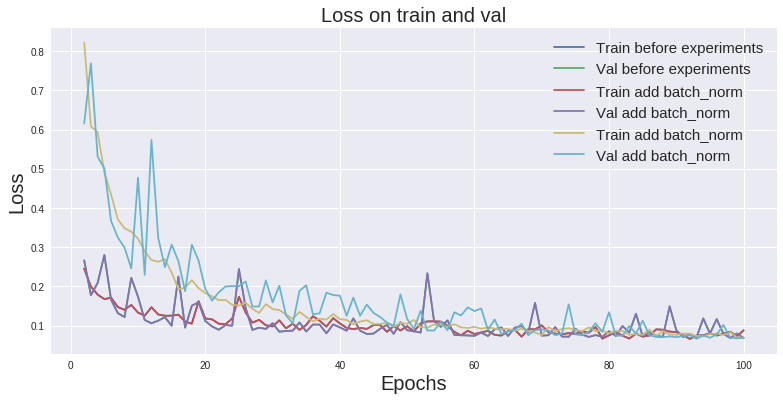

In [152]:
for i in range(len(train_loss_experiments)):
  num_epochs = train_loss_experiments[i][0].shape[0]
  plt.plot(range(2, num_epochs + 1), train_loss_experiments[i][0][1:], label = 'Train ' + train_loss_experiments[i][1])
  plt.plot(range(2, num_epochs + 1), val_loss_experiments[i][0][1:], label = 'Val ' + val_loss_experiments[i][1])

plt.legend(loc = 'upper right',  prop={'size': 15})
plt.title('Loss on train and val', size = 20)
plt.xlabel('Epochs', size = 20)
plt.ylabel('Loss', size = 20)
plt.show()

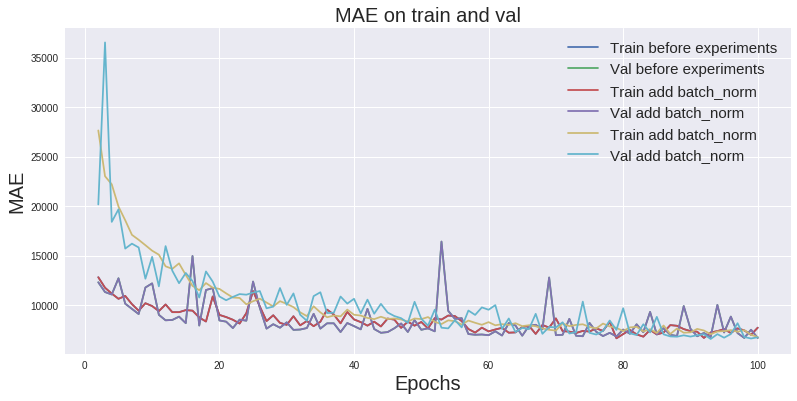

In [153]:
for i in range(len(train_mae_experiments)):
  num_epochs = train_mae_experiments[i][0].shape[0]
  plt.plot(range(2, num_epochs + 1), train_mae_experiments[i][0][1:], label = 'Train ' + train_mae_experiments[i][1])
  plt.plot(range(2, num_epochs + 1), val_mae_experiments[i][0][1:], label = 'Val ' + val_mae_experiments[i][1])

plt.legend(loc = 'upper right',  prop={'size': 15})
plt.title('MAE on train and val', size = 20)
plt.xlabel('Epochs', size = 20)
plt.ylabel('MAE', size = 20)
plt.show()

Сильного улучшения мы не получлии, но замечу что судя по графику val стал стабильнее учиться (в середине не такие большие пики)

### Parallel convolution layers

In [0]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX).cuda()
        
        self.conv_a = nn.Conv1d(64, out_size, kernel_size=3, padding=1).cuda()
        self.conv_b = nn.Conv1d(64, out_size, kernel_size=3, padding=1).cuda()

        self.norm_a = nn.BatchNorm1d(out_size).cuda()
        self.norm_b = nn.BatchNorm1d(out_size).cuda()

        self.pool_a = GlobalMaxPooling().cuda()
        self.pool_b = GlobalMaxPooling().cuda()
 
        self.relu = nn.ReLU().cuda()
        self.dense = nn.Linear(out_size * 2, out_size).cuda()

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        a = self.pool_a(self.norm_a(self.conv_a(h)))
        b = self.pool_b(self.norm_b(self.conv_b(h)))
        
        # Apply the layers as defined above. Add some ReLUs before dense. 
        return self.dense(self.relu(torch.cat([a, b], dim=1)))

In [0]:
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX).cuda()
 
        self.conv1_a = nn.Conv1d(64, out_size, kernel_size=3, padding=1).cuda()
        self.conv1_b = nn.Conv1d(64, out_size, kernel_size=3, padding=1).cuda()

        self.norm1_a = nn.BatchNorm1d(out_size).cuda()
        self.norm1_b = nn.BatchNorm1d(out_size).cuda()

        self.relu_a = nn.ReLU().cuda()
        self.relu_b = nn.ReLU().cuda()
        
      
        self.pool1_a = nn.MaxPool1d(2).cuda()
        self.pool1_b = nn.MaxPool1d(2).cuda()
        
        self.conv2_a = nn.Conv1d(out_size, out_size * 2, kernel_size=3, padding=1).cuda()
        self.conv2_b = nn.Conv1d(out_size, out_size * 2, kernel_size=3, padding=1).cuda()

        self.norm2_a= nn.BatchNorm1d(out_size * 2).cuda()
        self.norm2_b= nn.BatchNorm1d(out_size * 2).cuda()

        self.pool2_a = GlobalMaxPooling().cuda()
        self.pool2_b = GlobalMaxPooling().cuda()
        
        self.relu = nn.ReLU().cuda()
        self.dense = nn.Linear(out_size * 4, out_size).cuda()

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        a = self.pool2_a(self.norm2_a(self.conv2_a(self.pool1_a(self.relu_a(self.norm1_a(self.conv1_a(h)))))))
        b = self.pool2_b(self.norm2_b(self.conv2_b(self.pool1_b(self.relu_b(self.norm1_b(self.conv1_b(h)))))))
        
        # Apply the layers as defined above. Add some ReLUs before dense. 
        return self.dense(self.relu(torch.cat([a, b], dim=1)))

In [156]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
train_losses, train_maes, val_losses, val_maes = train_model(model, opt, num_epochs = 100)

Training after 1 epochs
	Loss:	20.02682
	MAE:	54564.95104



Validation after 1 epochs
	Loss:	1.46618
	MAE:	71856.21685



Training after 11 epochs
	Loss:	0.29393
	MAE:	14858.75465



Validation after 11 epochs
	Loss:	0.30128
	MAE:	13588.76132



Training after 21 epochs
	Loss:	0.17895
	MAE:	11153.51831



Validation after 21 epochs
	Loss:	0.20974
	MAE:	11138.23527



Training after 31 epochs
	Loss:	0.12957
	MAE:	9572.40973



Validation after 31 epochs
	Loss:	0.15719
	MAE:	9971.90522



Training after 41 epochs
	Loss:	0.12023
	MAE:	9226.59885



Validation after 41 epochs
	Loss:	0.14627
	MAE:	9795.70452



Training after 51 epochs
	Loss:	0.09264
	MAE:	7807.76902



Validation after 51 epochs
	Loss:	0.11796
	MAE:	8930.34270



Training after 61 epochs
	Loss:	0.09441
	MAE:	8251.50715



Validation after 61 epochs
	Loss:	0.08503
	MAE:	7610.99783



Training after 71 epochs
	Loss:	0.08479
	MAE:	7542.57227



Validation after 71 epochs
	Loss:	0.07439
	MAE:	7105.66154



Training after 81 e

In [157]:
print("Best val loss during iteration = {} on epoch = {}, MAE on this epoch = {}"\
      .format(np.min(val_losses), np.argmin(val_losses), val_maes[np.argmin(val_losses)]))
print("Best val MAE during iteration = {} on epoch = {}, loss on this epoch = {}"\
      .format(np.min(val_maes), np.argmin(val_maes), val_losses[np.argmin(val_maes)]))

Best val loss during iteration = 0.06645665050185974 on epoch = 96, MAE on this epoch = 6632.160311989379
Best val MAE during iteration = 6632.160311989379 on epoch = 96, loss on this epoch = 0.06645665050185974


In [0]:
train_loss_experiments.append((np.copy(train_losses), 'add parallel convolution'))
train_mae_experiments.append((np.copy(train_maes), 'add parallel convolution'))

val_loss_experiments.append((np.copy(val_losses), 'add parallel convolution'))
val_mae_experiments.append((np.copy(val_maes), 'add parallel convolution'))

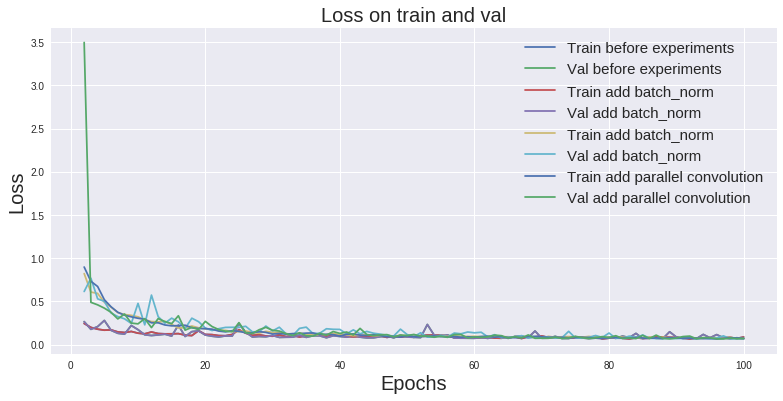

In [159]:
for i in range(len(train_loss_experiments)):
  num_epochs = train_loss_experiments[i][0].shape[0]
  plt.plot(range(2, num_epochs + 1), train_loss_experiments[i][0][1:], label = 'Train ' + train_loss_experiments[i][1])
  plt.plot(range(2, num_epochs + 1), val_loss_experiments[i][0][1:], label = 'Val ' + val_loss_experiments[i][1])

plt.legend(loc = 'upper right',  prop={'size': 15})
plt.title('Loss on train and val', size = 20)
plt.xlabel('Epochs', size = 20)
plt.ylabel('Loss', size = 20)
plt.show()

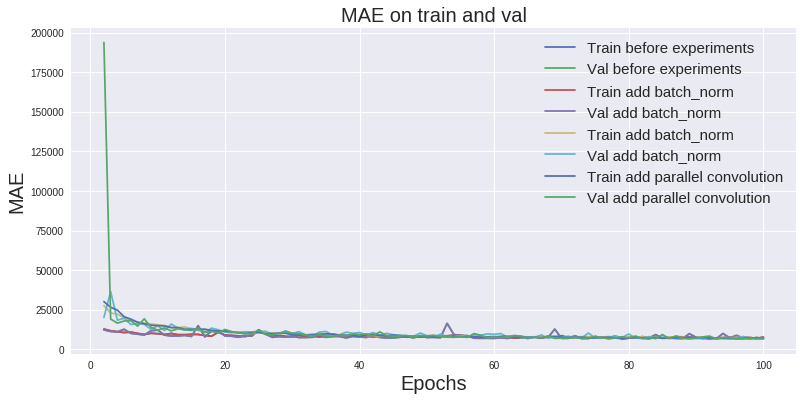

In [160]:
for i in range(len(train_mae_experiments)):
  num_epochs = train_mae_experiments[i][0].shape[0]
  plt.plot(range(2, num_epochs + 1), train_mae_experiments[i][0][1:], label = 'Train ' + train_mae_experiments[i][1])
  plt.plot(range(2, num_epochs + 1), val_mae_experiments[i][0][1:], label = 'Val ' + val_mae_experiments[i][1])

plt.legend(loc = 'upper right',  prop={'size': 15})
plt.title('MAE on train and val', size = 20)
plt.xlabel('Epochs', size = 20)
plt.ylabel('MAE', size = 20)
plt.show()

Пока улучшения не очень заметны (но они есть). У нас уже модель достаточно сложная, давайте добавим Dropout.

In [0]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.title_norm = nn.BatchNorm1d(64).cuda()
        
        self.desc_encoder = DescriptionEncoder(out_size = 128)
        self.desc_norm = nn.BatchNorm1d(128).cuda()
        
        # define layers for categorical features. A few dense layers would do.
        self.dense_1 = nn.Linear(n_cat_features, 512).cuda()
        self.norm_1 = nn.BatchNorm1d(512).cuda()
        self.relu_1 = nn.ReLU().cuda()
        self.drop = nn.Dropout(0.5).cuda()
        self.dense_2 = nn.Linear(512, 256).cuda()
        self.norm_2 = nn.BatchNorm1d(256).cuda()
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.output = nn.Linear(64 + 128 + 256, 1024).cuda()
        self.out_norm = nn.BatchNorm1d(1024).cuda()
        self.out_relu = nn.ReLU().cuda()
        self.out_drop = nn.Dropout(0.5).cuda()
        self.predict = nn.Linear(1024, 1).cuda()
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_norm(self.title_encoder(title_ix))
        desc_h = self.desc_norm(self.desc_encoder(desc_ix))
        
        # apply categorical encoder
        cat_h = self.norm_2(self.dense_2(self.drop(self.relu_1(self.norm_1(self.dense_1(cat_features))))))
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        
        output = self.predict(self.out_drop(self.out_relu(self.out_norm(self.output(joint_h)))))
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return output[:, 0]

In [162]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
train_losses, train_maes, val_losses, val_maes = train_model(model, opt, num_epochs = 100)

Training after 1 epochs
	Loss:	18.61303
	MAE:	44289.50426



Validation after 1 epochs
	Loss:	1.23605
	MAE:	28206.45832



Training after 11 epochs
	Loss:	0.63871
	MAE:	24450.03107



Validation after 11 epochs
	Loss:	0.50168
	MAE:	15723.52228



Training after 21 epochs
	Loss:	0.47228
	MAE:	19034.46873



Validation after 21 epochs
	Loss:	0.30719
	MAE:	13205.03729



Training after 31 epochs
	Loss:	0.39367
	MAE:	17884.35188



Validation after 31 epochs
	Loss:	0.23082
	MAE:	11842.64274



Training after 41 epochs
	Loss:	0.35972
	MAE:	16986.51019



Validation after 41 epochs
	Loss:	0.12918
	MAE:	9449.08637



Training after 51 epochs
	Loss:	0.32094
	MAE:	15904.35694



Validation after 51 epochs
	Loss:	0.11888
	MAE:	8903.56766



Training after 61 epochs
	Loss:	0.28812
	MAE:	14942.95881



Validation after 61 epochs
	Loss:	0.19770
	MAE:	11340.72923



Training after 71 epochs
	Loss:	0.25255
	MAE:	13930.43858



Validation after 71 epochs
	Loss:	0.16645
	MAE:	10514.77756



Training af

In [163]:
print("Best val loss during iteration = {} on epoch = {}, MAE on this epoch = {}"\
      .format(np.min(val_losses), np.argmin(val_losses), val_maes[np.argmin(val_losses)]))
print("Best val MAE during iteration = {} on epoch = {}, loss on this epoch = {}"\
      .format(np.min(val_maes), np.argmin(val_maes), val_losses[np.argmin(val_maes)]))

Best val loss during iteration = 0.08199449188130743 on epoch = 94, MAE on this epoch = 7499.5489187602125
Best val MAE during iteration = 7499.5489187602125 on epoch = 94, loss on this epoch = 0.08199449188130743


In [0]:
train_loss_experiments.append((np.copy(train_losses), 'add dropout'))
train_mae_experiments.append((np.copy(train_maes), 'add dropout'))

val_loss_experiments.append((np.copy(val_losses), 'add dropout'))
val_mae_experiments.append((np.copy(val_maes), 'add dropout'))

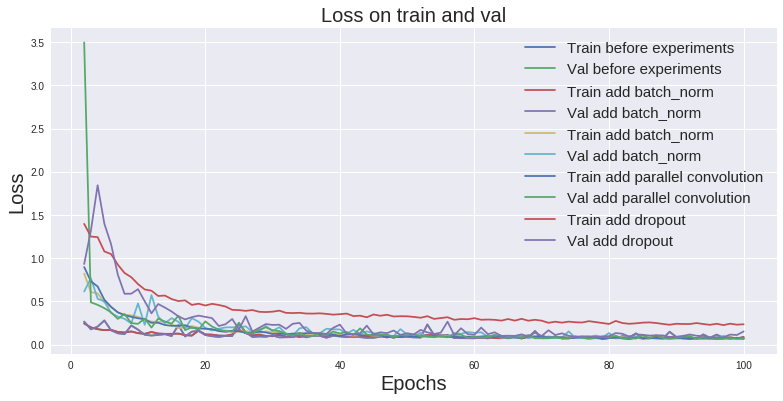

In [165]:
for i in range(len(train_loss_experiments)):
  num_epochs = train_loss_experiments[i][0].shape[0]
  plt.plot(range(2, num_epochs + 1), train_loss_experiments[i][0][1:], label = 'Train ' + train_loss_experiments[i][1])
  plt.plot(range(2, num_epochs + 1), val_loss_experiments[i][0][1:], label = 'Val ' + val_loss_experiments[i][1])

plt.legend(loc = 'upper right',  prop={'size': 15})
plt.title('Loss on train and val', size = 20)
plt.xlabel('Epochs', size = 20)
plt.ylabel('Loss', size = 20)
plt.show()

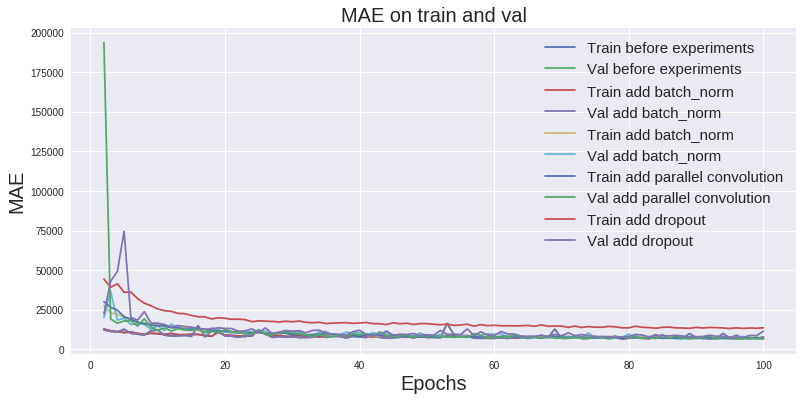

In [166]:
for i in range(len(train_mae_experiments)):
  num_epochs = train_mae_experiments[i][0].shape[0]
  plt.plot(range(2, num_epochs + 1), train_mae_experiments[i][0][1:], label = 'Train ' + train_mae_experiments[i][1])
  plt.plot(range(2, num_epochs + 1), val_mae_experiments[i][0][1:], label = 'Val ' + val_mae_experiments[i][1])

plt.legend(loc = 'upper right',  prop={'size': 15})
plt.title('MAE on train and val', size = 20)
plt.xlabel('Epochs', size = 20)
plt.ylabel('MAE', size = 20)
plt.show()

Судя по train модель с dropout не дообучилась (но скор на val сравнимый с предедущими экспериментами). Давайте обучим еще 50 эпох и посмотрим как будут вести себя графики

In [167]:
train_losses, train_maes, val_losses, val_maes = train_model(model, opt, num_epochs = 50)

Training after 1 epochs
	Loss:	0.23278
	MAE:	13421.26391



Validation after 1 epochs
	Loss:	0.08993
	MAE:	7754.34695



Training after 11 epochs
	Loss:	0.20852
	MAE:	12547.86686



Validation after 11 epochs
	Loss:	0.09569
	MAE:	8001.05051



Training after 21 epochs
	Loss:	0.20117
	MAE:	12144.11690



Validation after 21 epochs
	Loss:	0.08134
	MAE:	7540.98222



Training after 31 epochs
	Loss:	0.20500
	MAE:	12328.05737



Validation after 31 epochs
	Loss:	0.10805
	MAE:	8805.17497



Training after 41 epochs
	Loss:	0.19109
	MAE:	11828.67839



Validation after 41 epochs
	Loss:	0.07229
	MAE:	6974.40750





In [0]:
train_losses_all = np.concatenate([train_loss_experiments[-1][0], train_losses], axis = 0)
val_losses_all = np.concatenate([val_loss_experiments[-1][0], val_losses], axis = 0)

train_maes_all = np.concatenate([train_mae_experiments[-1][0], train_maes], axis = 0)
val_maes_all = np.concatenate([val_mae_experiments[-1][0], val_maes], axis = 0)

In [169]:
print("Best val loss during iteration = {} on epoch = {}, MAE on this epoch = {}"\
      .format(np.min(val_losses), np.argmin(val_losses_all), val_maes_all[np.argmin(val_losses_all)]))
print("Best val MAE during iteration = {} on epoch = {}, loss on this epoch = {}"\
      .format(np.min(val_maes), np.argmin(val_maes_all), val_losses_all[np.argmin(val_maes_all)]))

Best val loss during iteration = 0.0690530448445892 on epoch = 144, MAE on this epoch = 6781.589081648284
Best val MAE during iteration = 6781.589081648284 on epoch = 144, loss on this epoch = 0.0690530448445892


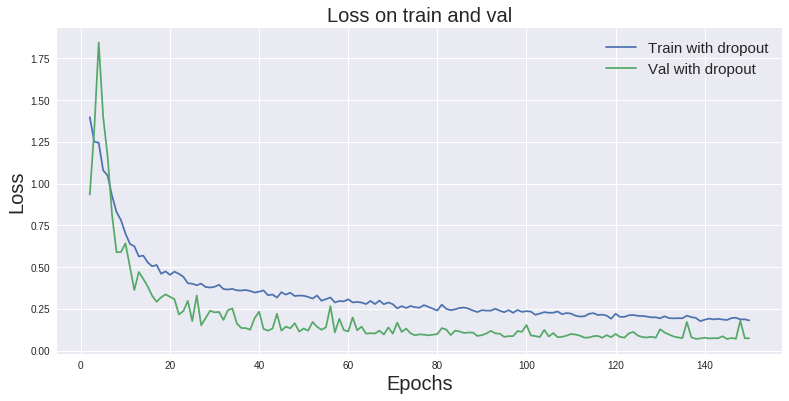

In [170]:
num_epochs = train_losses_all.shape[0]
plt.plot(range(2, num_epochs + 1), train_losses_all[1:], label = 'Train with dropout')
plt.plot(range(2, num_epochs + 1), val_losses_all[1:], label = 'Val with dropout')

plt.legend(loc = 'upper right',  prop={'size': 15})
plt.title('Loss on train and val', size = 20)
plt.xlabel('Epochs', size = 20)
plt.ylabel('Loss', size = 20)
plt.show()

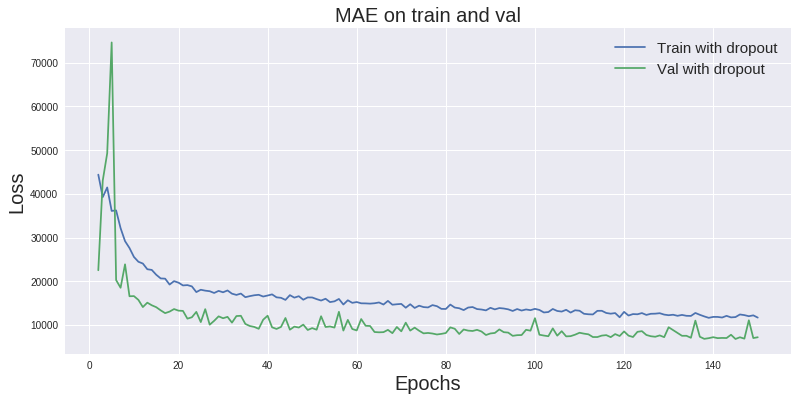

In [171]:
num_epochs = train_losses_all.shape[0]
plt.plot(range(2, num_epochs + 1), train_maes_all[1:], label = 'Train with dropout')
plt.plot(range(2, num_epochs + 1), val_maes_all[1:], label = 'Val with dropout')

plt.legend(loc = 'upper right',  prop={'size': 15})
plt.title('MAE on train and val', size = 20)
plt.xlabel('Epochs', size = 20)
plt.ylabel('Loss', size = 20)
plt.show()

Drop-out не принес значителньой пользы, но с ним модель ведетс себя гораздо стабильнее. Поэтому оставим его (тем более дальше наша модель будет только усложняться). Сохраним последний loss и назовем его 'Step A' и далее будем использовать 150 эпох для обучения

In [0]:
train_loss_experiments[-1] = (np.copy(train_losses_all), 'Step A')
val_loss_experiments[-1] = (np.copy(val_losses_all), 'Step A')
train_mae_experiments[-1] = (np.copy(train_maes_all), 'Step A')
val_mae_experiments[-1] = (np.copy(val_maes_all), 'Step A')

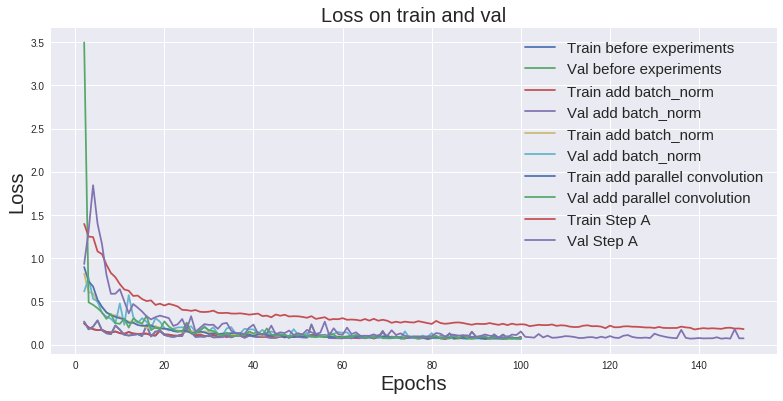

In [175]:
for i in range(len(train_loss_experiments)):
  num_epochs = train_loss_experiments[i][0].shape[0]
  plt.plot(range(2, num_epochs + 1), train_loss_experiments[i][0][1:], label = 'Train ' + train_loss_experiments[i][1])
  plt.plot(range(2, num_epochs + 1), val_loss_experiments[i][0][1:], label = 'Val ' + val_loss_experiments[i][1])

plt.legend(loc = 'upper right',  prop={'size': 15})
plt.title('Loss on train and val', size = 20)
plt.xlabel('Epochs', size = 20)
plt.ylabel('Loss', size = 20)
plt.show()

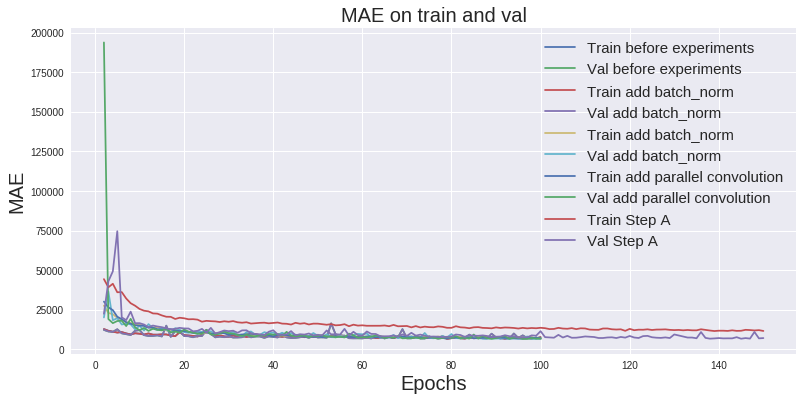

In [176]:
for i in range(len(train_mae_experiments)):
  num_epochs = train_mae_experiments[i][0].shape[0]
  plt.plot(range(2, num_epochs + 1), train_mae_experiments[i][0][1:], label = 'Train ' + train_mae_experiments[i][1])
  plt.plot(range(2, num_epochs + 1), val_mae_experiments[i][0][1:], label = 'Val ' + val_mae_experiments[i][1])

plt.legend(loc = 'upper right',  prop={'size': 15})
plt.title('MAE on train and val', size = 20)
plt.xlabel('Epochs', size = 20)
plt.ylabel('MAE', size = 20)
plt.show()

## B

#### Different pooling

In [0]:
class GlobalAveragePooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x, index):
        ssum = torch.sum(torch.einsum('ijb,ib->ijb', x, index), dim = self.dim).transpose(0, 1)
        return (ssum / torch.sum(index, dim = self.dim)).transpose(0, 1)

In [0]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX).cuda()
        
        self.conv_a = nn.Conv1d(64, out_size, kernel_size=3, padding=1).cuda()
        self.conv_b = nn.Conv1d(64, out_size, kernel_size=3, padding=1).cuda()

        self.norm_a = nn.BatchNorm1d(out_size).cuda()
        self.norm_b = nn.BatchNorm1d(out_size).cuda()

        self.pool_a = GlobalMaxPooling().cuda()
        self.pool_b = GlobalMaxPooling().cuda()
        
        self.avg_pool = GlobalAveragePooling().cuda()
 
        self.relu = nn.ReLU().cuda()
        self.dense = nn.Linear(out_size * 2, out_size).cuda()

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        
        #find PAD
        pad = torch.abs(torch.sign(text_ix - PAD_IX)).float()
        
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        a = self.norm_a(self.conv_a(h))
        print(a.size())
        print(pad.size())
        print('TEST')
        mean_a = self.avg_pool(a, pad)
        print(mean_a.size())
        a = self.pool_a(a)
        print(a.size())
        b = self.pool_b(self.norm_b(self.conv_b(h)))
        
        # Apply the layers as defined above. Add some ReLUs before dense. 
        return self.dense(self.relu(torch.cat([a, b], dim=1)))

In [0]:
encoder = TitleEncoder()

In [262]:
for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch, max_len = 20, verbose = False):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64).cuda()
        encoder(title_ix)
        break

torch.Size([32, 64, 11])
torch.Size([32, 11])
TEST
torch.Size([32, 64, 11])
torch.Size([64, 32])
torch.Size([32, 64])
torch.Size([32, 64])


In [0]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.title_norm = nn.BatchNorm2d(64).cuda()

        self.desc_encoder = DescriptionEncoder(out_size = 128)
        self.desc_norm = nn.BatchNorm2d(128).cuda()
        
        # define layers for categorical features. A few dense layers would do.
        self.dense_1 = nn.Linear(n_cat_features, 512).cuda()
        self.norm_1 = nn.BatchNorm2d(512)
        self.relu_1 = nn.ReLU().cuda()
        self.drop_1 = nn.Dropout(0.1).cuda()
        self.dense_2 = nn.Linear(512, 256).cuda()
        self.norm_2 = nn.BatchNorm2d(256)
        self.relu_2 = nn.ReLU().cuda()
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.output = nn.Linear(64 + 128 + 256, 1024).cuda()
        self.out_norm = nn.BatchNorm2d(1024).cuda()
        self.out_relu = nn.ReLU().cuda()
        self.drop_2 = nn.Dropout(0.3).cuda()
        self.predict = nn.Linear(1024, 1).cuda()
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_norm(self.title_encoder(title_ix))
        desc_h = self.desc_norm(self.desc_encoder(desc_ix))
        
        # apply categorical encoder
        cat_h = self.relu_2(self.norm_2(self.dense_2(self.drop_1(self.relu_1(self.norm_1(self.dense_1(cat_features)))))))
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        
        output = self.predict(self.drop_2(self.out_relu(self.output(joint_h))))
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return output[:, 0]

### A short report

Please tell us what you did and how did it work.

`<YOUR_TEXT_HERE>`, i guess...